In [30]:
import re
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from nltk.corpus import stopwords
from transformers import BertModel, BertTokenizer

import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda")
print(device)

cuda


In [31]:
train_file_path = r"C:\Users\Stepan\Desktop\vk_test\train_spam.csv"
test_file_path = r"C:\Users\Stepan\Desktop\vk_test\test_spam.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
train_df[:1]

,text_type,text
0,ham,make sure alex knows his birthday is over in f...


In [32]:
train_df['text'][1]

'a resume for john lavorato thanks vince i will get moving on it right away molly vince j kaminski 02 21 2001 05 55 pm to molly magee hou ect ect cc vince j kaminski hou ect ect subject a resume for john lavorato molly please make arrangements for the interview with this candidate for a trading position interviews with john lavorato jeff shankman gary hickerson stinson gibner i talked to him in new york and he is considering other opportunities so we have to act fast i think john will like him more than punit thanks'

In [33]:
train_df.groupby('text_type').describe()

text                                                            \
           count unique                                                top   
text_type                                                                    
ham        11469  11458  SPAM ALERT  🚔  User:     Username: @DillyBubbl...   
spam        4809   4809  plzz visit my website moviesgodml to get all m...   

                
          freq  
text_type       
ham          7  
spam         1

In [34]:
count_ham_value, count_spam_value = train_df['text_type'].value_counts()


print(f'How many a ham message: {count_ham_value}\nHow many a spam message: {count_spam_value}')

How many a ham message: 11469
How many a spam message: 4809


In [35]:
train_df.info()
train_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


# Step 2:

Lets us extract some Features as well

In [36]:
train_df["Length"] = train_df["text"].apply(len) # get the length of the text message
train_df["num_words"] = train_df["text"].apply(lambda x: len(re.findall(r'\w+', x))) # Count the number of words in the message 
train_df['label'] = train_df['text_type'].map({'ham': 0, 'spam': 1})
train_df.head()

,text_type,text,Length,num_words,label
0,ham,make sure alex knows his birthday is over in f...,86,16,0
1,ham,a resume for john lavorato thanks vince i will...,520,97,0
2,spam,plzz visit my website moviesgodml to get all m...,126,22,1
3,spam,urgent your mobile number has been awarded wit...,139,23,1
4,ham,overview of hr associates analyst project per ...,733,127,0


This will help our model to have more features so it can predict based on length of messages

<Axes: xlabel='Length', ylabel='Count'>

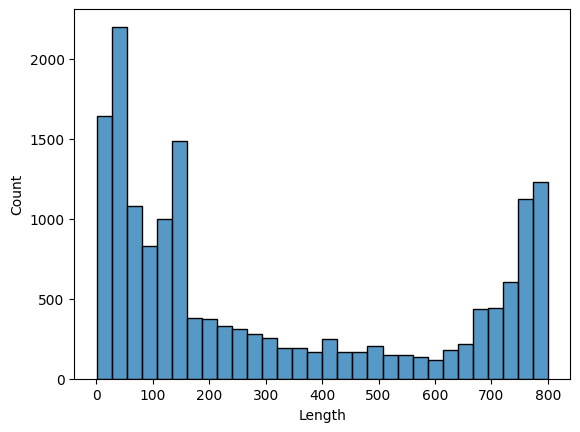

In [37]:
sns.histplot(train_df["Length"], bins=30)

# Questions

what is Maximum Length of Message some one sent and what is that message

In [38]:
train_df["Length"].max()

800

In [39]:
train_df[train_df["Length"]==800]["text"].iloc[0]

'welcome to jefferson pilot s gateway to wealth as one of the industry s premier producers you must continually seek qualified cutting edge services financial profiles concept profiles professional is a personal and business analysis tool that analyzes a client s insurance investment and financial planning goals to help them see their situation today compared to their objectives market profiles professional is an ideal tool for true financial planning it not only provides a thorough analysis including asset allocation but it can calculate tax implications in a client s plan due to its modular format it can be used for specific planning needs as well as more comprehensive planning benefits this software not only provides exceptional analysis but excels in providing simple as well as comprehe'

what is Mininum Length of Message some one sent and what is that message

In [40]:
train_df[train_df["Length"] == train_df["Length"].min()]["text"].iloc[0]

'🙁'

Conclusion: The Mininum Length of message is 1 and it seems to be just EMOJII ^^

<Axes: xlabel='text_type', ylabel='Length'>

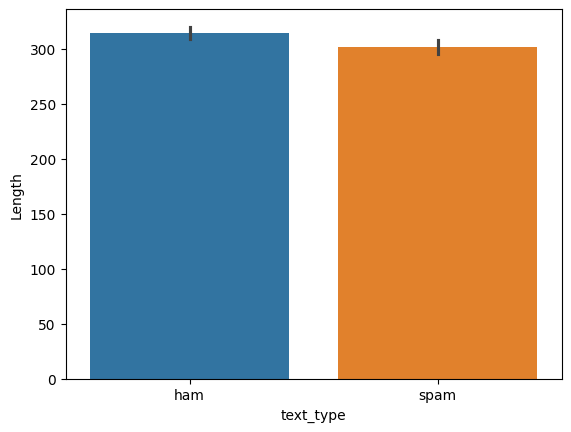

In [41]:
sns.barplot(data=train_df, x='text_type', y='Length', hue="text_type")

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

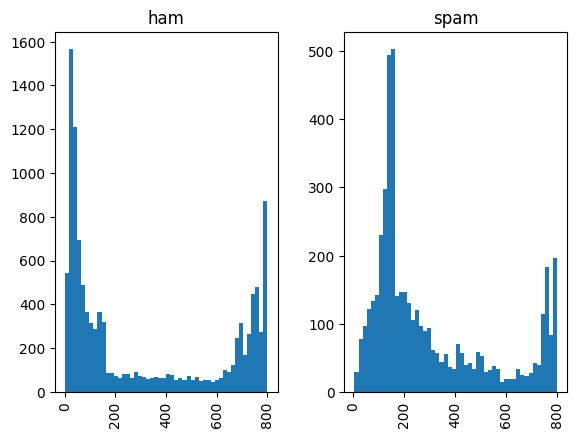

In [42]:
train_df.hist(column='Length',by='text_type', bins=50)

# Loading the Pre-trained BERT model

Let's now load a pre-trained BERT model.